# Preliminary

In [1]:
# connect google drive to colab session

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# get data from google drive
!cp "/content/drive/MyDrive/others/Time Series/Gold Price/gold_price_data.csv" .

# Import data and modules

In [4]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor

In [6]:
from fbprophet import Prophet

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.holtwinters import ExponentialSmoothing

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
path="/content/gold_price_data.csv"
df=pd.read_csv(path)
df.shape

(10787, 2)

# Analysis

In [9]:
df.head()

,Date,Value
0,1970-01-01,35.2
1,1970-04-01,35.1
2,1970-07-01,35.4
3,1970-10-01,36.2
4,1971-01-01,37.4


In [10]:
df.tail()

,Date,Value
10782,2020-03-09,1672.50
10783,2020-03-10,1655.70
10784,2020-03-11,1653.75
10785,2020-03-12,1570.70
10786,2020-03-13,1562.80


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10787 entries, 0 to 10786
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    10787 non-null  object 
 1   Value   10787 non-null  float64
dtypes: float64(1), object(1)
memory usage: 168.7+ KB


In [12]:
df.describe()

,Value
count,10787.000000
mean,653.596634
std,434.030848
min,35.100000
25%,349.200000
50%,409.350000
75%,1061.625000
max,1895.000000


In [13]:
# reformat the csv file with values and date as index
# missing dates are to be inserted into the csv with 'Value' as NAN
# csv shall reflect per day observations

df2=df.copy()
df2['Date']=pd.to_datetime(df2['Date'])
df2.index=df2['Date']
df2.drop(['Date'], axis=1, inplace=True)

df_temp=df2.copy()

df2=df2.asfreq('D')
df2

,Value
Date,
1970-01-01,35.20
1970-01-02,NaN
1970-01-03,NaN
1970-01-04,NaN
1970-01-05,NaN
...,...
2020-03-09,1672.50
2020-03-10,1655.70
2020-03-11,1653.75


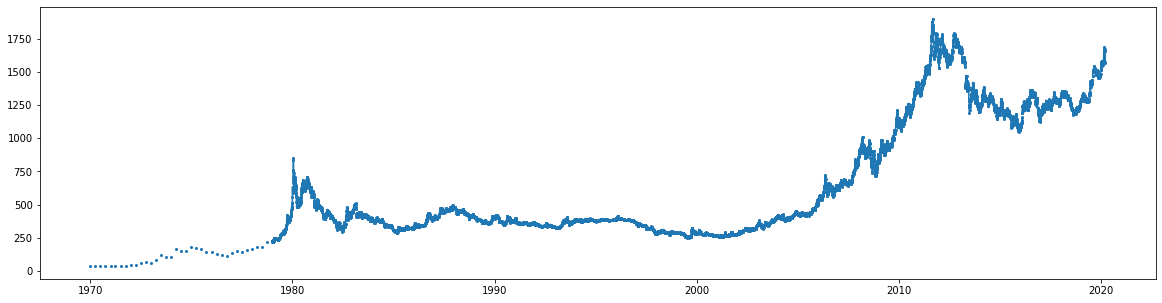

In [14]:
# plot the graph

plt.figure(figsize=(20,5))
plt.plot(df2['Value'], "-o",  markersize=2); plt.show()

Above graph shows that there are missing values at the beginning of graph

In [15]:
# check for NAN values

df2.isna().sum()

Value    7548
dtype: int64

In [16]:
# fill the missing values with linear interpolation (data imputation)

df3=df2.interpolate(method="linear", limit_direction ='forward')
df3.head()

,Value
Date,
1970-01-01,35.200000
1970-01-02,35.198889
1970-01-03,35.197778
1970-01-04,35.196667
1970-01-05,35.195556


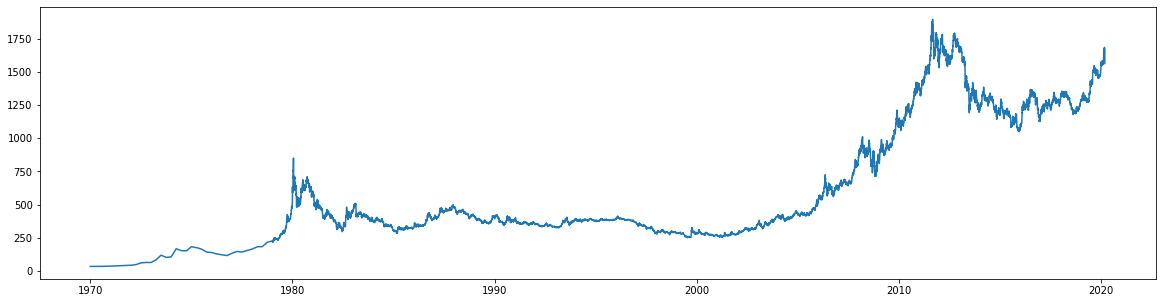

In [17]:
# re-plot the series after data imputation

plt.figure(figsize=(20,5))
plt.plot(df3['Value'], markersize=2); plt.show()

In [18]:
# function to check whether series is stationary or not
# using Augmented Dickey-Fuller test

def check_stationarity(series):
    adftest = adfuller(series, autolag='AIC')
    p=adftest[1]
    if p>=0.05:
        print("Non stationary\t; p-value - ",p)
    else:
        print("Stationary\t; p-value - ",p)
        

In [19]:
check_stationarity(df3['Value'].dropna())

Non stationary	; p-value -  0.9608544164174698


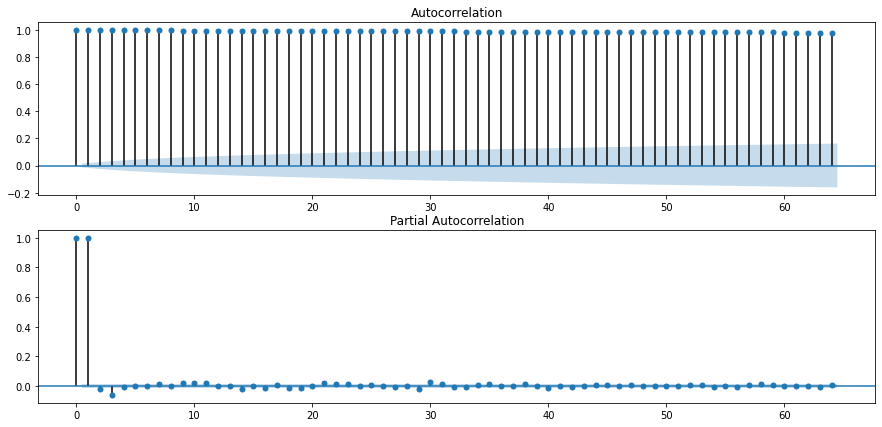

In [20]:
# Plot ACF/PACF charts to analyze the series

_,ax=plt.subplots(2,1, figsize=(15,7))
plot_acf(df3, ax[0], lags=64)
plot_pacf(df3, ax[1], lags=64)
plt.show()

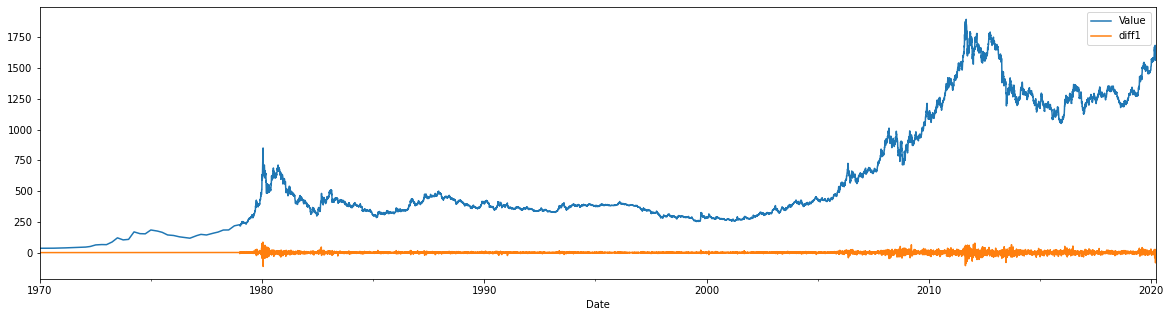

In [21]:
#  As the series is non-stationary, lets do differencing and check its graph

df_temp=df3.copy()
df_temp['diff1']=df_temp['Value'] - df_temp['Value'].shift(1)
df_temp.plot(figsize=(20,5))

In [22]:
# Lets verify whether differenced series is stationary

check_stationarity(df_temp['diff1'].dropna())

Stationary	; p-value -  0.0


 After differencing, we could successfully make the series stationary

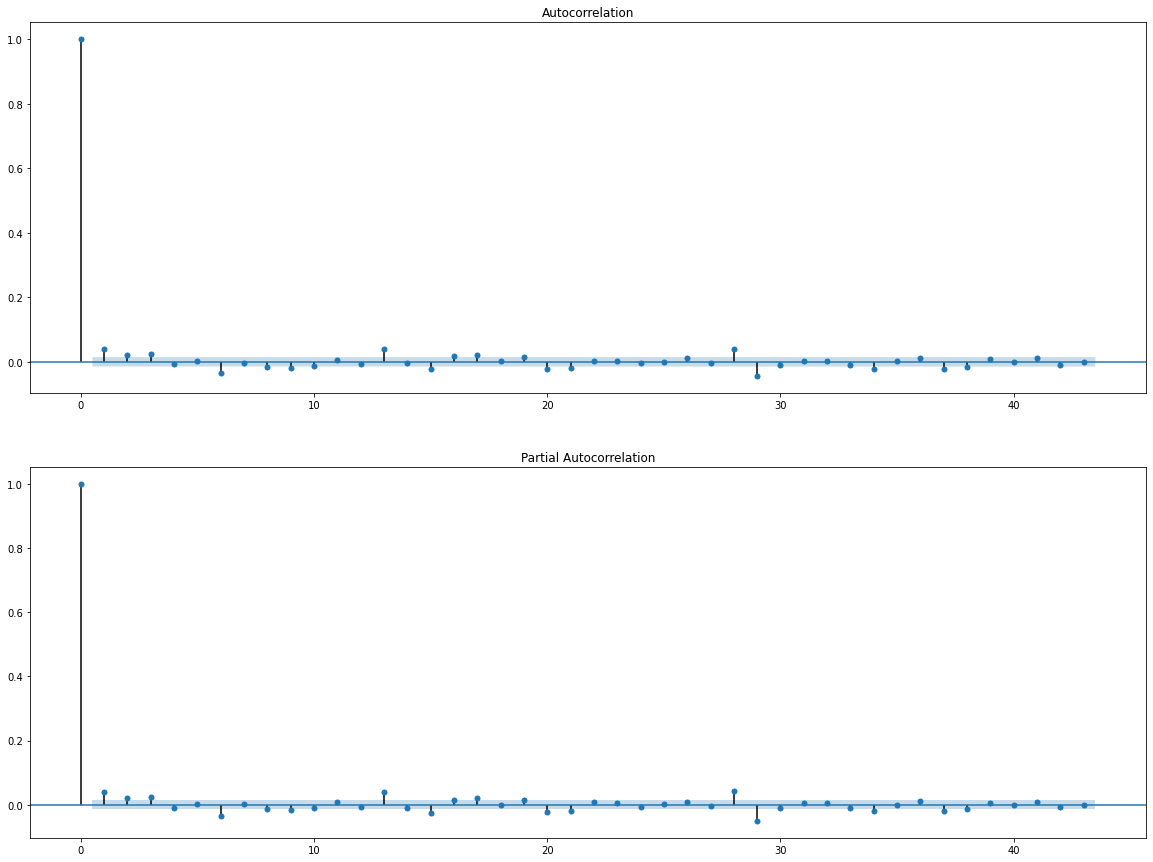

In [23]:
# Just see the ACF/PACF plots of differenced series

_,ax=plt.subplots(2,1, figsize=(20,15))
plot_acf(df_temp['diff1'].dropna(), ax[0])
plot_pacf(df_temp['diff1'].dropna(), ax[1])
plt.show()

# Model Building

To get the best model to fit on historical data and do best forecasting, we will use variety of models

Whole time series length	 18335
Train/Val split			 16501


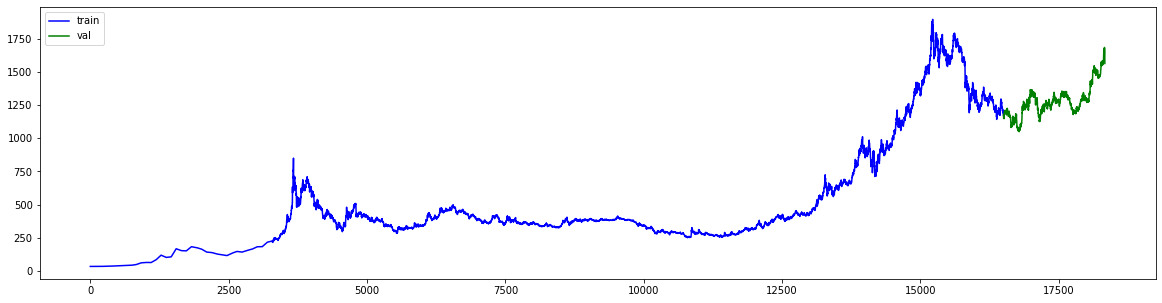

In [24]:
# train/val split of time series

data=df3["Value"]
print("Whole time series length\t", data.shape[0])

N0=data.shape[0]
N=int(N0*0.9)
print("Train/Val split\t\t\t", N)

train_data=data[:N]
val_data=data[N:]

plt.figure(figsize=(20,5))
plt.plot( np.arange(0,N), data[:N], color="b" )
plt.plot( np.arange(N,N0), data[N:], color="g" )
plt.legend(["train", "val"], loc="upper left")
plt.show()

The blue curve is the historical(training) data and green is our vaidation data

In [25]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error


def get_metrics(true_values, prediction):
    mae=mean_absolute_error(true_values, prediction).round(3)
    mape=mean_absolute_percentage_error(true_values, prediction).round(3)
    mse=mean_squared_error(true_values, prediction).round(3)
    rmse=np.sqrt(mse).round(3)

    return mape, mae, mse, rmse


In [26]:
# function to plot historcal, validation data alongwith prediction of model

def plot_predictions(predicted_data):
    plt.figure(figsize=(20,5))
    plt.plot( np.arange(0,N), data[:N], color="b")          # historical data
    plt.plot( np.arange(N,N0), data[N:], color="g" )        # validation data
    plt.plot( np.arange(N,N0), predicted_data, color="r" )  # predicted data
    plt.legend(["train", "val", "forecasted"], loc="upper left")
    plt.show()    
    

## Exponential Smoothing

In [27]:
# create config list for exponential Smoothing to get the hyper-parameters

def exp_smoothing_config_list():
    config_ll = []
 
    t_params = ['add', None]
    d_params = [True, False]
    s_params = ['add', None]
    p_params = [52, None]

    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    cfg = [t,d,s,p]
                    config_ll.append(cfg)
     
    return config_ll


In [28]:
# get the config list of hyper-parameters

config_ll=exp_smoothing_config_list()

In [ ]:
# train the best model using best config 

saved_model=None
saved_config=None
error=np.inf

for config in tqdm(config_ll):
    t,d,s,p=config
    try:
        model = ExponentialSmoothing(train_data, trend=t, damped=d, seasonal=s, seasonal_periods=p)
        hw_model=model.fit()
        pred = hw_model.forecast( len(val_data) )

        mae=mean_absolute_error(val_data, pred)
        if mae<error:
            error=mae
            saved_config=config
            saved_model=hw_model
    except:
        pass


In [38]:
# do forecasting of the model and check by metrics its performance

pred_Y = saved_model.forecast( len(val_data) )

mape, mae, mse, rmse = get_metrics(val_data, pred_Y)
print("MAPE {}, MAE : {}, MSE : {}, RMSE : {} ".format(mape, mae, mse, rmse))

MAPE 0.055, MAE : 73.084, MSE : 10243.06, RMSE : 101.208 


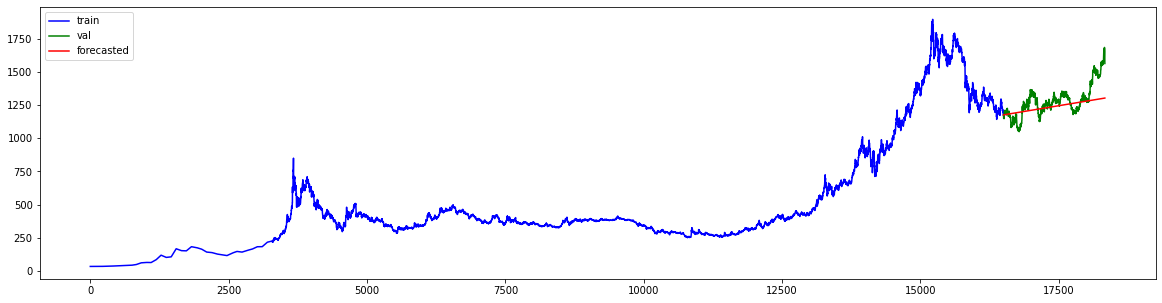

In [39]:
# plot the predictions by model

plot_predictions(pred_Y)

We can see that the model prediction is to a large extent a straight line being red in colour against the validation data in green coloured curve

## Machine Learning


In [40]:
# train/val split of data with formatting in such a way that can be fed to the ML models

def train_val_ml_split(data, lags):
    d2=data.copy()

    for i in range(1, lags+1):
        col_name="lag-"+str(i)
        d2[col_name]=data.shift(i)

    d2=d2.dropna()
    train=d2.loc[:"2015-03-06"]
    val=d2.loc["2015-03-07":]
    
    return train, val


In [42]:
# split train/val data
data_train_ml, data_val_ml = train_val_ml_split(df3, 5)

# convert it to numpy format
data_train_ml=data_train_ml.to_numpy()
data_val_ml=data_val_ml.to_numpy()

# split the data with historical data vector and its forecasted value
train_X=data_train_ml[:,1:]
train_Y=data_train_ml[:,0]

val_X=data_val_ml[:,1:]
val_Y=data_val_ml[:,0]

# perform scaling operations to prepare data before training
sc=StandardScaler()
train_X=sc.fit_transform(train_X)
val_X=sc.transform(val_X)

In [43]:
data_train_ml

array([[  35.19444444,   35.19555556,   35.19666667,   35.19777778,
          35.19888889,   35.2       ],
       [  35.19333333,   35.19444444,   35.19555556,   35.19666667,
          35.19777778,   35.19888889],
       [  35.19222222,   35.19333333,   35.19444444,   35.19555556,
          35.19666667,   35.19777778],
       ...,
       [1199.5       , 1212.75      , 1212.5       , 1213.        ,
        1213.5       , 1214.        ],
       [1202.        , 1199.5       , 1212.75      , 1212.5       ,
        1213.        , 1213.5       ],
       [1175.75      , 1202.        , 1199.5       , 1212.75      ,
        1212.5       , 1213.        ]])

In [45]:
data_val_ml

[[1173.33333333 1175.75       1202.         1199.5        1212.75
  1212.5       ]
 [1170.91666667 1173.33333333 1175.75       1202.         1199.5
  1212.75      ]
 [1168.5        1170.91666667 1173.33333333 1175.75       1202.
  1199.5       ]
 ...
 [1653.75       1655.7        1672.5        1676.21666667 1679.93333333
  1683.65      ]
 [1570.7        1653.75       1655.7        1672.5        1676.21666667
  1679.93333333]
 [1562.8        1570.7        1653.75       1655.7        1672.5
  1676.21666667]]


In [47]:
train_X.shape, train_Y.shape, val_X.shape, val_Y.shape

((16496, 5), (16496,), (1834, 5), (1834,))

### Random Forest

In [ ]:
# get the different hyper-parameters for grid search for random-forest model
param_grid = [
{'n_estimators': [3, 10, 30], 'max_depth': [3, 4, 6, 8, 12]},
{'bootstrap': [False], 'n_estimators': [3, 6, 10], 'max_depth': [3, 4, 6, 12]},
]

# create a model
forest_reg = RandomForestRegressor()

# do grid-search to get the best model
grid_search = GridSearchCV(forest_reg, param_grid, cv=10, 
                           scoring='neg_mean_squared_error', 
                           return_train_score=True, verbose=2)


grid_search.fit(train_X, train_Y)

In [49]:
# get the best hyper-parameters
print(grid_search.best_params_)

{'max_depth': 12, 'n_estimators': 3}


In [50]:
# get the best model for the best chosen hyper-parameters
forest_reg = grid_search.best_estimator_

In [51]:
# make predictions on val data
pred_Y=forest_reg.predict(val_X)

# check its metrics
mape, mae, mse, rmse = get_metrics(val_Y, pred_Y)
print("MAPE {}, MAE : {}, MSE : {}, RMSE : {} ".format(mape, mae, mse, rmse))

MAPE 0.006, MAE : 7.637, MSE : 117.332, RMSE : 10.832 


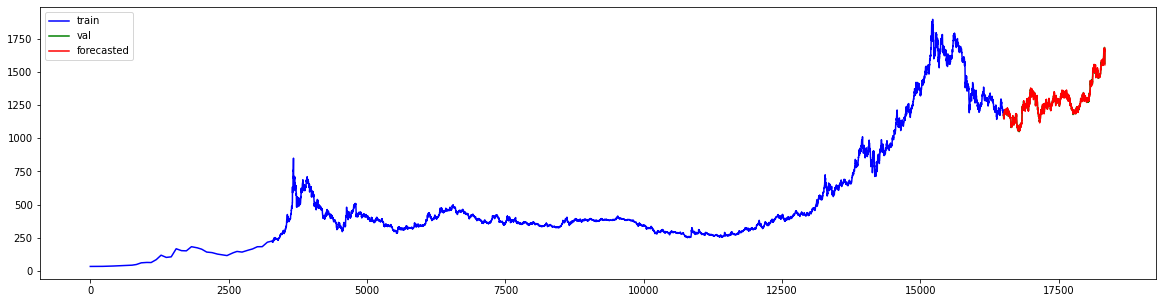

In [52]:
# plot the curves
plot_predictions(pred_Y)

As we can see, that random-forest predictions overlaps the validation data of time series

### XGBoost

In [ ]:
param_grid = {
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

xgb_reg = XGBRegressor()

grid_search = GridSearchCV(xgb_reg, param_grid, cv=10, 
                           scoring='neg_mean_squared_error', 
                           return_train_score=True, verbose=2)

grid_search.fit(train_X, train_Y)

In [54]:
print(grid_search.best_params_)

{'gamma': 1.5, 'max_depth': 3, 'subsample': 0.6}


In [55]:
xgb_reg = grid_search.best_estimator_

In [56]:
pred_Y=xgb_reg.predict(val_X)

mape, mae, mse, rmse = get_metrics(val_Y, pred_Y)
print("MAPE {}, MAE : {}, MSE : {}, RMSE : {} ".format(mape, mae, mse, rmse))

MAPE 0.005, MAE : 6.98, MSE : 97.946, RMSE : 9.897 


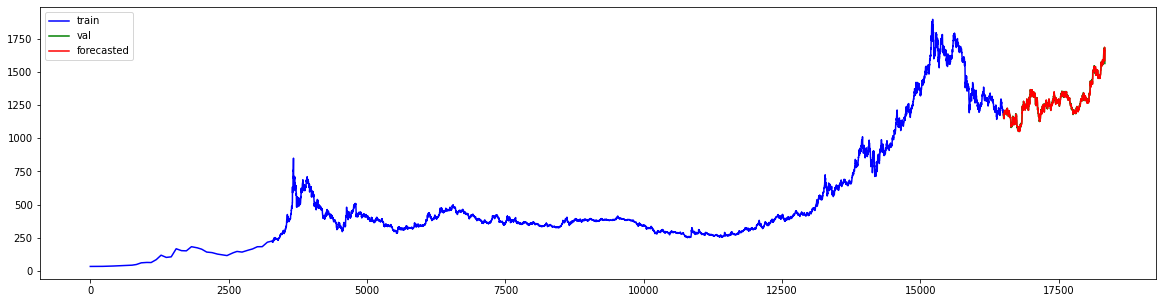

In [57]:
plot_predictions(pred_Y)

### Polynomial Regression

In [ ]:
param_grid = {
        'poly_features__degree': [3, 5, 7],
        'poly_features__include_bias': [False, True],
        }

polynomial_regressor = Pipeline([
                                  ("poly_features", PolynomialFeatures()),
                                  ("lin_reg", LinearRegression()),
                                ])
                                  
grid_search = GridSearchCV(polynomial_regressor, param_grid, cv=10, 
                           scoring='neg_mean_squared_error', 
                           return_train_score=True, verbose=2)

grid_search.fit(train_X, train_Y)

In [59]:
print(grid_search.best_params_)

{'poly_features__degree': 3, 'poly_features__include_bias': True}


In [60]:
poly_reg = grid_search.best_estimator_

In [61]:
pred_Y=poly_reg.predict(val_X)

mape, mae, mse, rmse = get_metrics(val_Y, pred_Y)
print("MAPE {}, MAE : {}, MSE : {}, RMSE : {} ".format(mape, mae, mse, rmse))

MAPE 0.004, MAE : 5.169, MSE : 66.597, RMSE : 8.161 


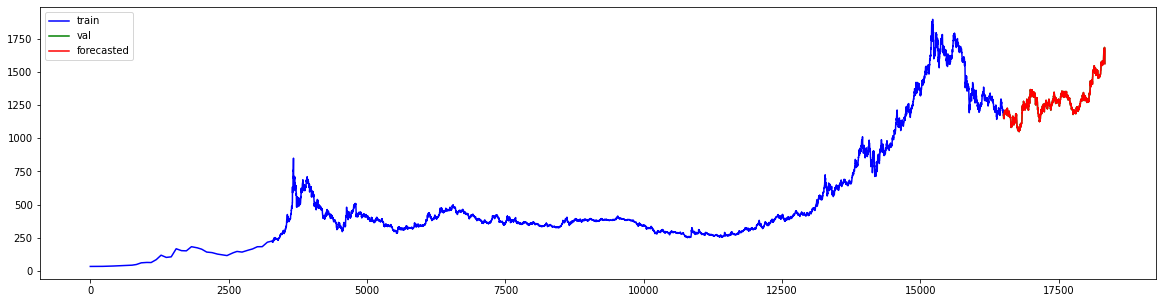

In [62]:
plot_predictions(pred_Y)

### Suport Vector Regressor

In [ ]:
param_grid = [ {'kernel': ['linear', 'rbf'], 'gamma' : ['auto','scale'] }, 
                {'kernel': ['poly'], "degree":[3, 5], 'gamma' : ['auto','scale'] }, 
                ]

svm_reg = SVR()

grid_search = GridSearchCV(svm_reg, param_grid, cv=10, 
                           scoring='neg_mean_squared_error', 
                           return_train_score=True, verbose=2)

grid_search.fit(train_X, train_Y)

In [64]:
print(grid_search.best_params_)

{'gamma': 'auto', 'kernel': 'linear'}


In [65]:
svm_reg = grid_search.best_estimator_

In [66]:
pred_Y=svm_reg.predict(val_X)

mape, mae, mse, rmse = get_metrics(val_Y, pred_Y)
print("MAPE {}, MAE : {}, MSE : {}, RMSE : {} ".format(mape, mae, mse, rmse))

MAPE 0.006, MAE : 7.081, MSE : 101.112, RMSE : 10.055 


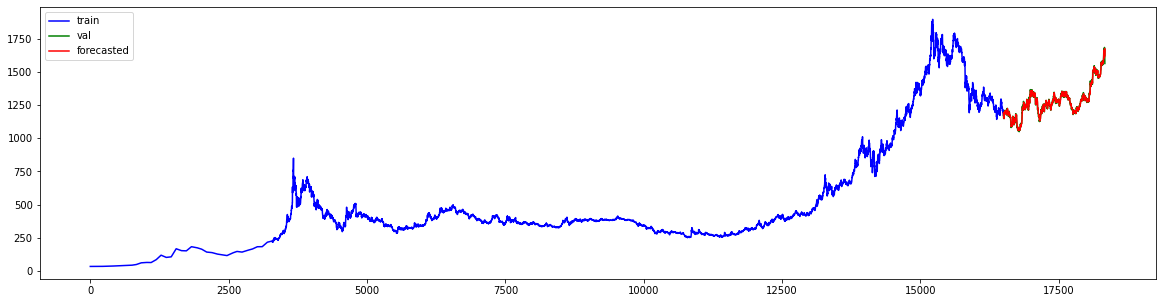

In [67]:
plot_predictions(pred_Y)

## Recurrent Networks

We will now use recurrent neural networks to model the time series using RNN and LSTM

In [68]:
import tensorflow
from tensorflow.keras.layers import Input, LSTM, GRU, Flatten
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

from tensorflow.keras import backend as K

In [69]:
tensorflow.config.run_functions_eagerly(True)

In [74]:
# reshape train/val data for neural networks

timesteps=5
train_X2=train_X.reshape(-1,1,timesteps)
val_X2=val_X.reshape(-1,1,timesteps)

train_X2.shape, val_X2.shape

((16496, 1, 5), (1834, 1, 5))

In [70]:
# plotting the model loss and learning rate while training progresses

def plot_training_history(history):
  train_loss=history.history['loss']
  val_loss=history.history['val_loss']  
  lr=history.history['lr'] 

  X=np.arange(1, len(lr)+1)

  _,ax=plt.subplots(1,2, figsize=(20,6))
  ax=ax.ravel()
  ax[0].plot(X, train_loss, "-bo")
  ax[0].plot(X, val_loss, "-ro")  
  ax[0].legend(["train", "val"])
  ax[0].set_title("Loss curve")

  ax[1].plot(X, lr)
  ax[1].set_title("learning rate")

  plt.show()
  

### RNN

In [71]:
# create RNN network accepting a vector of data of previous timesteps 
# and predicting new value of next time step

def create_rnn_model(n_timesteps=5):
  inp=Input((1, n_timesteps))
  x=inp
  x=SimpleRNN(units=256, return_sequences=True)(x)     # RNN layer
  x=Dropout(0.3)(x)
  x=Flatten()(x)
  x=Dense(1)(x)

  model=Model(inp, x)
  return model

# create model

K.clear_session()  
model=create_rnn_model(5)
model.compile(optimizer=Adam(1E-2), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 5)]            0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 1, 256)            67072     
                                                                 
 dropout (Dropout)           (None, 1, 256)            0         
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 67,329
Trainable params: 67,329
Non-trainable params: 0
_________________________________________________________________


In [75]:
# scheduler for changing learning rate

def schedule(epoch, lr):
    if epoch<=10:
        return 1E-1
    elif epoch>10 and epoch<=20:
        return 1E-2
    else:
        return 1E-3
lrs=LearningRateScheduler(schedule)


# teain model for 40 epochs

history=model.fit(train_X2, train_Y, 
          epochs=40,
          batch_size=512,
          callbacks=[lrs],
          validation_data=(val_X2, val_Y),
          validation_batch_size=1
          )

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


33/33 [==============================] - 20s 621ms/step - loss: 195541.1562 - val_loss: 329654.8125 - lr: 0.1000
Epoch 2/40
33/33 [==============================] - 22s 671ms/step - loss: 46099.3555 - val_loss: 75309.8906 - lr: 0.1000
Epoch 3/40
33/33 [==============================] - 21s 670ms/step - loss: 25007.3262 - val_loss: 25510.1562 - lr: 0.1000
Epoch 4/40
33/33 [==============================] - 17s 528ms/step - loss: 12885.4990 - val_loss: 6772.7290 - lr: 0.1000
Epoch 5/40
33/33 [==============================] - 19s 591ms/step - loss: 7389.4053 - val_loss: 2895.3989 - lr: 0.1000
Epoch 6/40
33/33 [==============================] - 21s 670ms/step - loss: 5221.0688 - val_loss: 1027.9230 - lr: 0.1000
Epoch 7/40
33/33 [==============================] - 21s 670ms/step - loss: 4607.4717 - val_loss: 4713.7271 - lr: 0.1000
Epoch 8/40
33/33 [==============================] - 22s 671ms/step - loss: 4194.7852 - val_loss: 507.1313 - lr: 0.1000
Epoch 9/40
33/33 [=========================

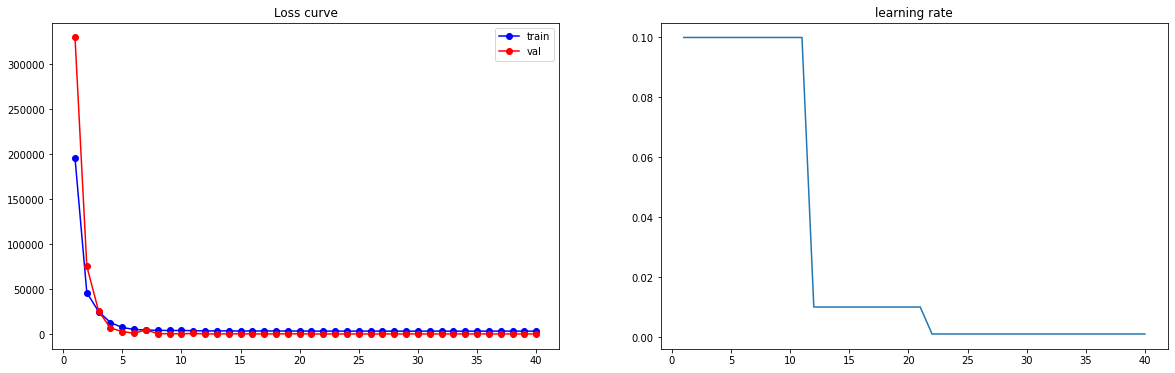

In [76]:
# plot training curves : train-loss, val-loss and learninig rate for 40 epochs

plot_training_history(history)

In [78]:
pred_Y=model.predict(val_X2)

mape, mae, mse, rmse = get_metrics(val_Y, pred_Y)
print("MAPE {}, MAE : {}, MSE : {}, RMSE : {} ".format(mape, mae, mse, rmse))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


MAPE 0.008, MAE : 10.459, MSE : 213.04, RMSE : 14.596 


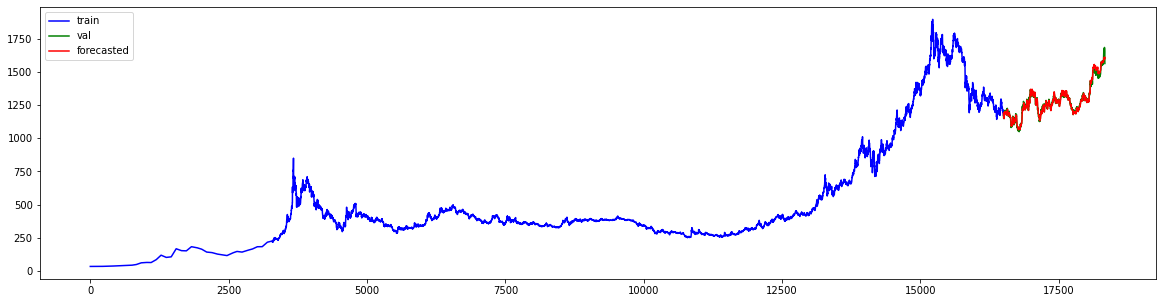

In [79]:
# plot the predictions on graph

plot_predictions(pred_Y)

### LSTM

In [81]:
# create LSTM model

def create_lstm_model(n_timesteps=5):
  inp=Input((1, n_timesteps))
  x=inp
  x=LSTM(units=256, return_sequences=True)(x)     # LSTM layer
  x=Dropout(0.3)(x)
  x=Flatten()(x)
  x=Dense(1)(x)

  model=Model(inp, x)
  return model


K.clear_session()  
model=create_lstm_model(5)
model.compile(optimizer=Adam(1E-2), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 5)]            0         
                                                                 
 lstm (LSTM)                 (None, 1, 256)            268288    
                                                                 
 dropout (Dropout)           (None, 1, 256)            0         
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________


In [83]:
# train model

history=model.fit(train_X2, train_Y, 
          epochs=40,
          batch_size=512,
          callbacks=[lrs],
          validation_data=(val_X2, val_Y),
          validation_batch_size=1
          )

Epoch 1/40
 1/33 [..............................] - ETA: 3s - loss: 157852.6250

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


33/33 [==============================] - 24s 732ms/step - loss: 97073.7109 - val_loss: 316309.0625 - lr: 0.1000
Epoch 2/40
33/33 [==============================] - 22s 698ms/step - loss: 47790.3750 - val_loss: 133707.0469 - lr: 0.1000
Epoch 3/40
33/33 [==============================] - 22s 696ms/step - loss: 26264.9180 - val_loss: 50088.0430 - lr: 0.1000
Epoch 4/40
33/33 [==============================] - 19s 606ms/step - loss: 14039.2617 - val_loss: 15656.2998 - lr: 0.1000
Epoch 5/40
33/33 [==============================] - 19s 592ms/step - loss: 8181.7021 - val_loss: 7071.3960 - lr: 0.1000
Epoch 6/40
33/33 [==============================] - 22s 696ms/step - loss: 5556.7007 - val_loss: 4820.9990 - lr: 0.1000
Epoch 7/40
33/33 [==============================] - 18s 570ms/step - loss: 4215.2222 - val_loss: 1762.0353 - lr: 0.1000
Epoch 8/40
33/33 [==============================] - 43s 1s/step - loss: 3297.2688 - val_loss: 1699.1562 - lr: 0.1000
Epoch 9/40
33/33 [==========================

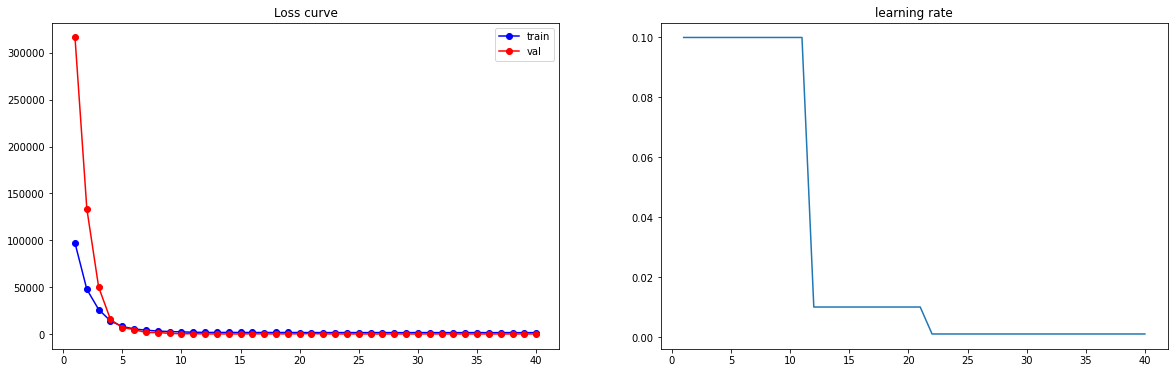

In [84]:
plot_training_history(history)

In [86]:
pred_Y=model.predict(val_X2)

mape, mae, mse, rmse = get_metrics(val_Y, pred_Y)
print("MAPE {}, MAE : {}, MSE : {}, RMSE : {} ".format(mape, mae, mse, rmse))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


MAPE 0.007, MAE : 9.306, MSE : 183.482, RMSE : 13.546 


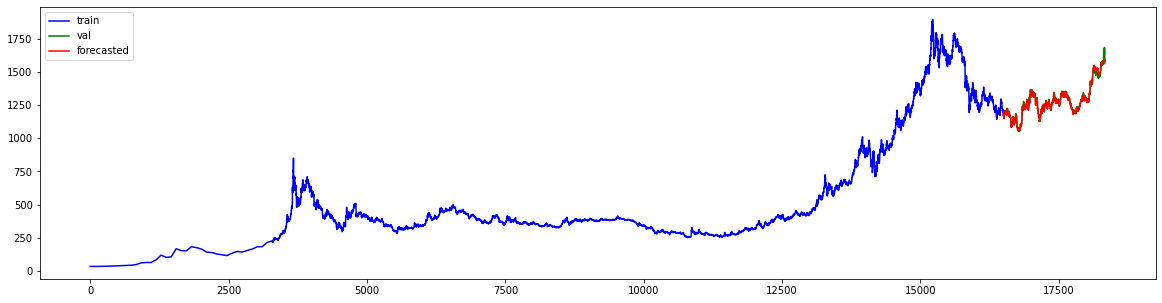

In [87]:
plot_predictions(pred_Y)

<br><br>

# Results

<center><b style="text-align:center" width="100%" >Model Performance</b></center>


<table width="90%" align-content="center" >
<tr><th style="text-align:center" >Model</th><th style="text-align:center" >Mean Absolute Error</th></tr>    
<tr><td style="text-align:center" >Polynomial Regression</td><td style="text-align:center" >5.169</td></tr>
<tr><td style="text-align:center" >XGBoost</td><td  style="text-align:center" >6.98</td></tr>
<tr><td style="text-align:center" >SVR</td><td style="text-align:center" >7.081</td></tr>
<tr><td style="text-align:center" >Random Forest</td><td style="text-align:center" >7.637</td></tr>
<tr><td style="text-align:center" >LSTM</td><td style="text-align:center" >9.306</td></tr>
</table>